<a href="https://colab.research.google.com/github/marichala/ML/blob/main/Healthcare_ML_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install required libraries
!pip install pandas scikit-learn imbalanced-learn matplotlib interpret requests

# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
import numpy as np
from interpret.glassbox import (LogisticRegression, ExplainableBoostingClassifier, ClassificationTree)
from interpret.blackbox import LimeTabular
from sklearn.ensemble import RandomForestClassifier

from interpret import show
from sklearn.metrics import f1_score, accuracy_score
import requests
import pickle

# URL of the CSV file in the GitHub repository
#file_url = "https://raw.githubusercontent.com/marichala/ML/refs/heads/ExplainableAI/healthcare-dataset-stroke-data.csv"
file_url="https://raw.githubusercontent.com/marichala/data_master/main/healthcare-dataset-stroke-data.csv"
# Load the CSV file into a pandas DataFrame
data = pd.read_csv(file_url)

# Set display options for pandas DataFrame
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 32.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 82.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 39.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 85.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 70.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 778.9/778.9 kB 40.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 52.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━

In [ ]:
# Show histogram for all columns to analyse the data
data.gender.hist()


In [ ]:
data.age.hist()

In [ ]:
data.hypertension.hist()

In [ ]:
data.heart_disease.hist()

In [ ]:
data.ever_married.hist()

In [ ]:
data.work_type.hist()

In [ ]:
data.Residence_type.hist()

In [ ]:
data.avg_glucose_level.hist()

In [ ]:
data.bmi.hist()

In [ ]:
data.smoking_status.hist()

In [ ]:
data.stroke.hist()

Each variable is converted in as many 0/1 variables as there are different values. Columns in the output are each named after a value; if the input is a DataFrame, the name of the original variable is prepended to the value.

In [2]:
categorical_cols = ["gender",
                            "ever_married",
                            "work_type",
                            "Residence_type",
                            "smoking_status"]

encoded = pd.get_dummies(data[categorical_cols], prefix=categorical_cols)
#encoded.info()

In [3]:
data = pd.concat([encoded, data], axis=1)
data.drop(categorical_cols, axis=1, inplace=True)

#data.info()#

# Impute missing values of BMI
data.bmi = data.bmi.fillna(0)

# Drop id as it is not relevant
if 'id' in data.columns:
  data.drop(['id'], axis=1, inplace=True)

#spliting features (X) and lables (y)
#Features = all columns in the dataset except the last column.... represented :(start default 0) to :-1 (minus 1 column from end)
X = data.iloc[:,:-1]
y = data.iloc[:,-1]

# Split the data for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=2021)

print("Before oversampling:", X_train.shape)
oversample = RandomOverSampler(sampling_strategy='minority')

# Convert to numpy and oversample
x_np = X_train.to_numpy()
y_np = y_train.to_numpy()

# Convert y to int before oversampling
y_np = y_np.astype(int)

x_np, y_np = oversample.fit_resample(x_np, y_np)

# Convert boolean values to 1.0 or 0.0
x_np = np.where(x_np == True, 1, x_np)
x_np = np.where(x_np == False, 0, x_np)

y_np = np.where(y_np == True, 1, y_np)
y_np = np.where(y_np == False, 0, y_np)

# Convert back to pandas
X_train = pd.DataFrame(x_np, columns=X_train.columns)
y_train = pd.Series(y_np, name=y_train.name)

# Check for non-numeric values in each column
for col in X_train.columns:
    if not pd.api.types.is_numeric_dtype(X_train[col]):
        print(f"Train Column '{col}' contains non-numeric values.")
        # Handle non-numeric values (e.g., convert to numeric or remove rows)
        # Example: Convert to numeric, coercing errors to NaN
        X_train[col] = pd.to_numeric(X_train[col], errors='coerce')
        # Or remove rows with non-numeric values:
        # X_train = X_train[pd.to_numeric(X_train[col], errors='coerce').notnull()]

# Convert columns to float if all values are numeric
for col in X_train.columns:
    if pd.api.types.is_numeric_dtype(X_train[col]):
        X_train[col] = X_train[col].astype(float)

# Check for non-numeric values in each column
for col in X_test.columns:
    if not pd.api.types.is_numeric_dtype(X_test[col]):
        print(f"Test Column '{col}' contains non-numeric values.")
        # Handle non-numeric values (e.g., convert to numeric or remove rows)
        # Example: Convert to numeric, coercing errors to NaN
        X_test[col] = pd.to_numeric(X_test[col], errors='coerce')
        # Or remove rows with non-numeric values:
        # X_train = X_train[pd.to_numeric(X_train[col], errors='coerce').notnull()]

# Convert columns to float if all values are numeric
for col in X_test.columns:
    if pd.api.types.is_numeric_dtype(X_test[col]):
        X_test[col] = X_test[col].astype(float)

X_test.info()
X_train.info()


Before oversampling: (4088, 21)
Train Column 'gender_Female' contains non-numeric values.
Train Column 'gender_Male' contains non-numeric values.
Train Column 'gender_Other' contains non-numeric values.
Train Column 'ever_married_No' contains non-numeric values.
Train Column 'ever_married_Yes' contains non-numeric values.
Train Column 'work_type_Govt_job' contains non-numeric values.
Train Column 'work_type_Never_worked' contains non-numeric values.
Train Column 'work_type_Private' contains non-numeric values.
Train Column 'work_type_Self-employed' contains non-numeric values.
Train Column 'work_type_children' contains non-numeric values.
Train Column 'Residence_type_Rural' contains non-numeric values.
Train Column 'Residence_type_Urban' contains non-numeric values.
Train Column 'smoking_status_Unknown' contains non-numeric values.
Train Column 'smoking_status_formerly smoked' contains non-numeric values.
Train Column 'smoking_status_never smoked' contains non-numeric values.
Train Col

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


col:  gender_Female


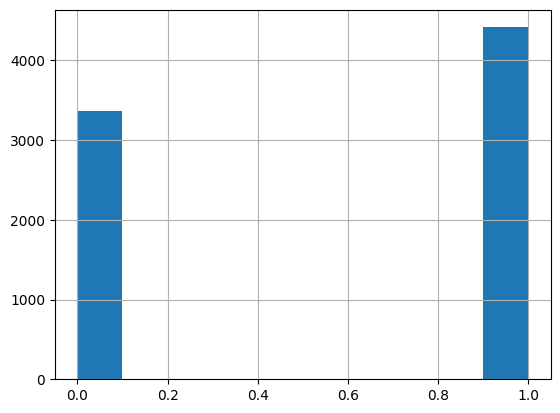

col:  gender_Male


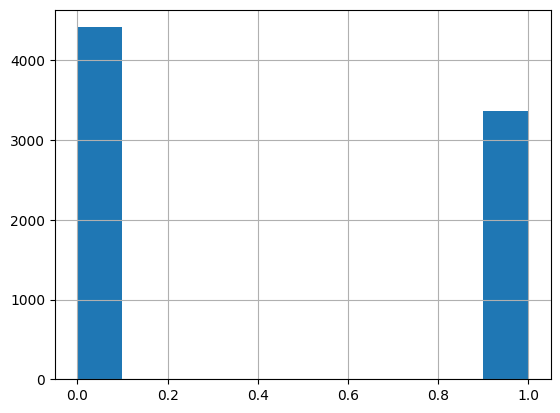

col:  gender_Other


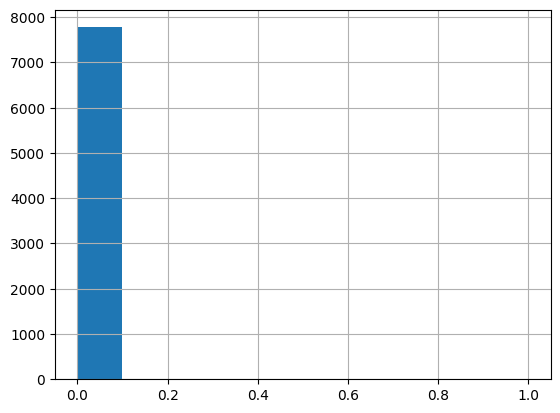

col:  ever_married_No


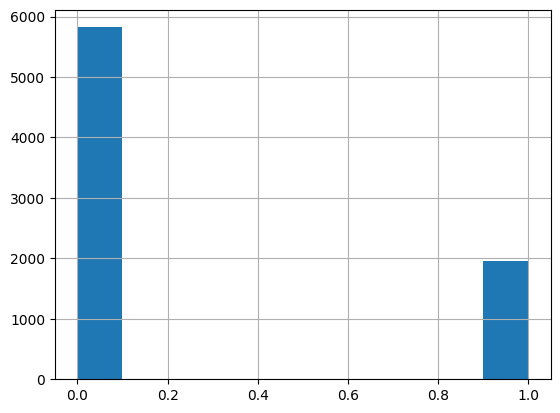

col:  ever_married_Yes


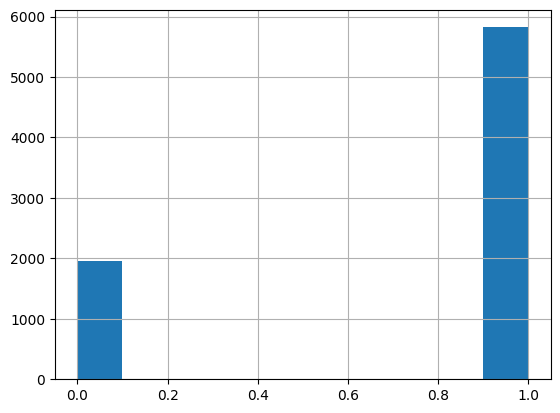

col:  work_type_Govt_job


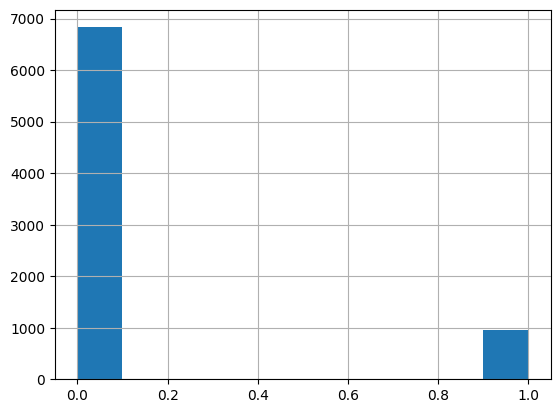

col:  work_type_Never_worked


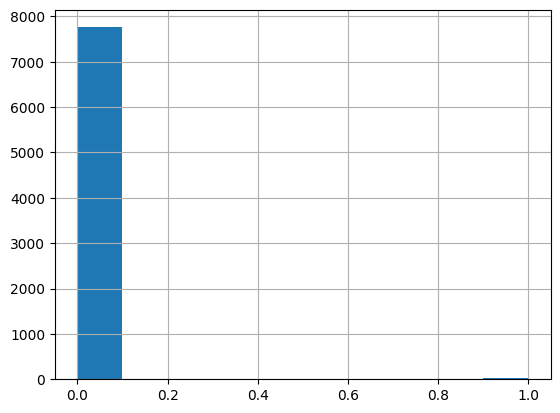

col:  work_type_Private


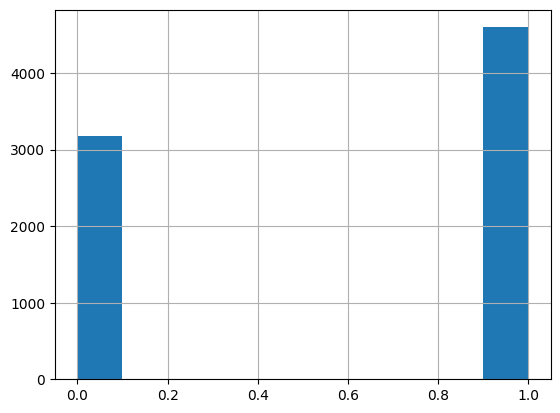

col:  work_type_Self-employed


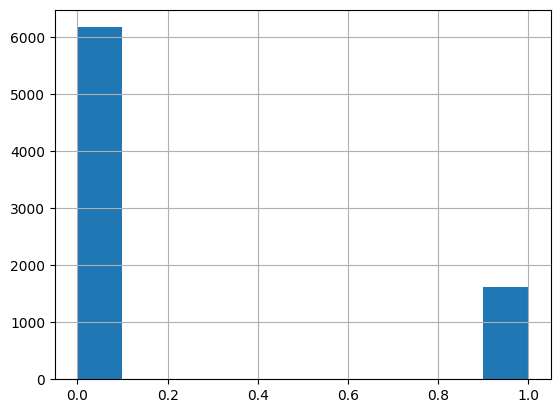

col:  work_type_children


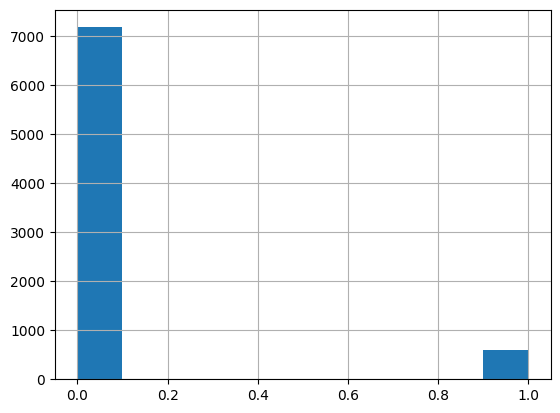

col:  Residence_type_Rural


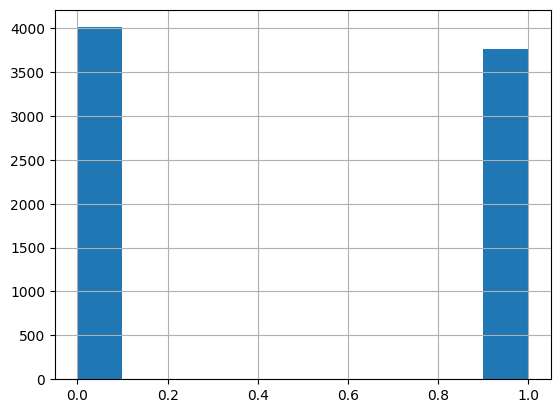

col:  Residence_type_Urban


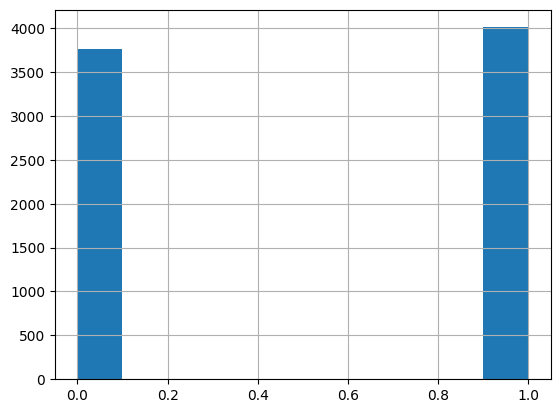

col:  smoking_status_Unknown


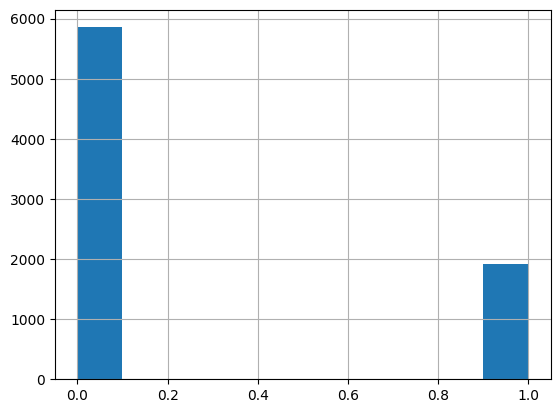

col:  smoking_status_formerly smoked


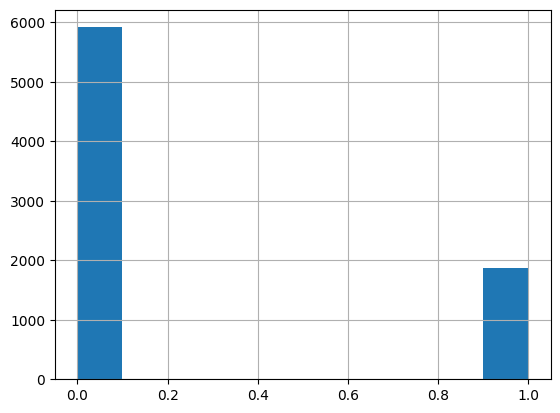

col:  smoking_status_never smoked


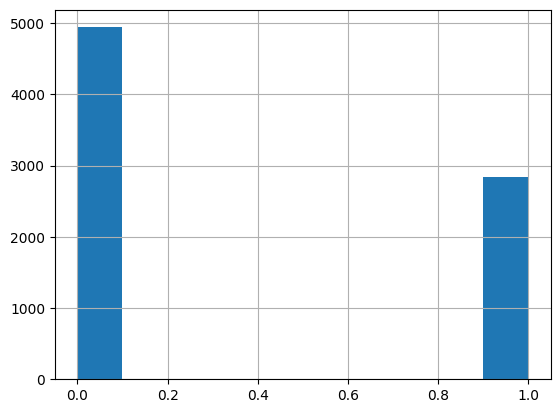

col:  smoking_status_smokes


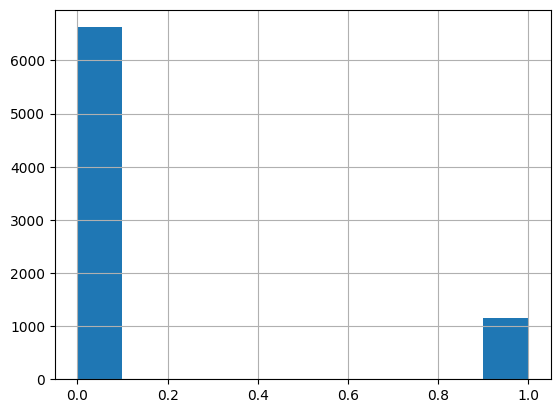

col:  age


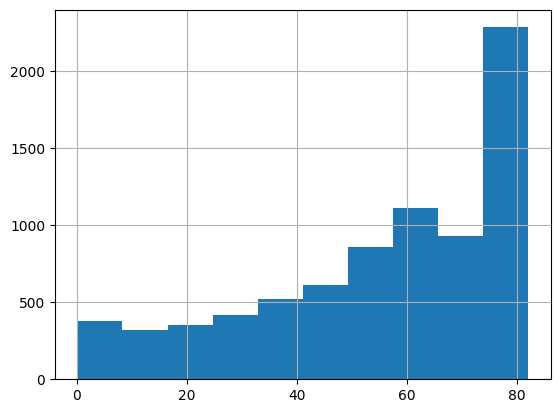

col:  hypertension


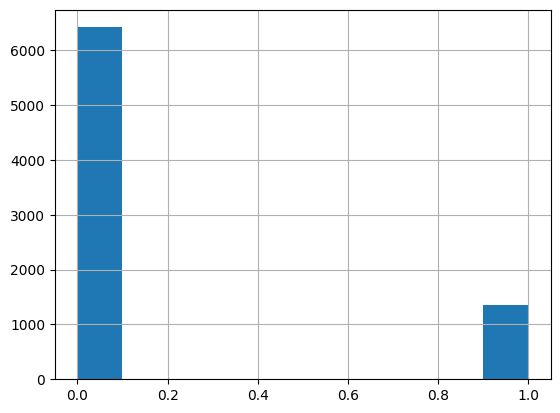

col:  heart_disease


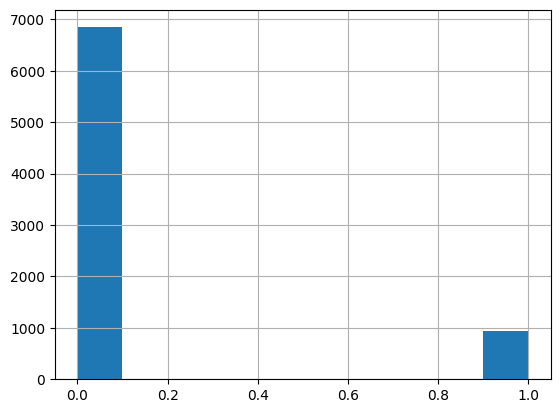

col:  avg_glucose_level


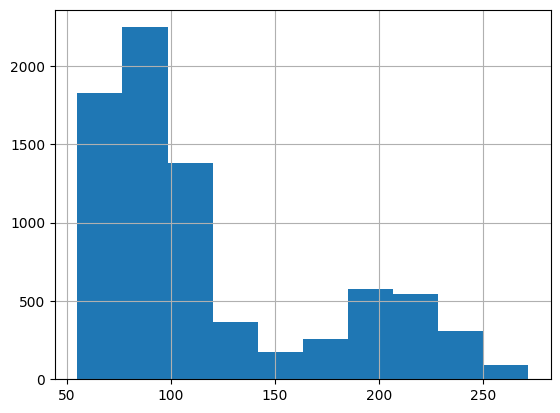

col:  bmi


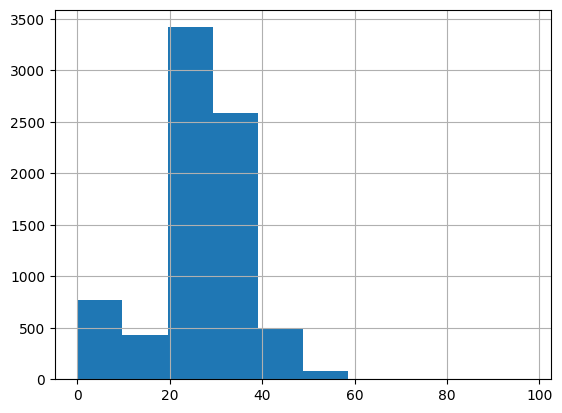

In [4]:
# Show histogram for all columns
columns = X_train.columns
for col in columns:
    print("col: ", col)
    X_train[col].hist()
    plt.show()

In [5]:
# %% Fit Explainable Boosting Machine
ebm = ExplainableBoostingClassifier(random_state=2021)
ebm.fit(X_train, y_train)
print("Training finished.")
y_pred = ebm.predict(X_test)
print(f"F1 Score {f1_score(y_test, y_pred, average='macro')}")
print(f"Accuracy {accuracy_score(y_test, y_pred)}")

Training finished.
F1 Score 0.5457087715152231
Accuracy 0.9227005870841487


In [7]:
# prompt: Download the trained model

import joblib

# Assuming 'ebm' is your trained ExplainableBoostingClassifier model
# Save the model to a file
joblib.dump(ebm, 'ebm_model.pkl')

# Download the saved model file
from google.colab import files
files.download('ebm_model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [2]:
# prompt: Load ebm_model.pkl from GitHub to make predictions

import joblib
import requests
from io import BytesIO

# Github URL of the model file
model_url = "https://github.com/maricharla/ML/raw/main/ebm_model.pkl"  # Replace with the actual URL

try:
    response = requests.get(model_url)
    response.raise_for_status()  # Raise an exception for bad status codes (4xx or 5xx)

    # Load the model from the BytesIO object
    model = joblib.load(BytesIO(response.content))

    # Example prediction (replace with your actual data)
    # Create a sample DataFrame for prediction
    sample_data = pd.DataFrame({
        'gender_Female': [1],
        'gender_Male': [0],
        'gender_Other': [0],
        'ever_married_No': [0],
        'ever_married_Yes': [1],
        'work_type_Govt_job': [0],
        'work_type_Never_worked': [0],
        'work_type_Private': [0],
        'work_type_Self-employed': [0],
        'work_type_children': [0],
        'Residence_type_Rural': [0],
        'Residence_type_Urban': [1],
        'smoking_status_Unknown': [0],
        'smoking_status_formerly smoked': [0],
        'smoking_status_never smoked': [0],
        'smoking_status_smokes': [0],
        'age': [50],
        'hypertension': [0],
        'heart_disease': [0],
        'avg_glucose_level': [100],
        'bmi': [30],
        'stroke': [0] #Dummy value, will be predicted
    })
    # Make a prediction using the loaded model
    predictions = model.predict(sample_data.drop('stroke', axis=1)) #Drop the stroke column as we are making a prediction
    print("Predictions:", predictions)


except requests.exceptions.RequestException as e:
    print(f"Error downloading model: {e}")
except Exception as e:
    print(f"Error loading model: {e}")

Error downloading model: 404 Client Error: Not Found for url: https://github.com/maricharla/ML/raw/main/ebm_model.pkl


In [12]:

# %% Explain locally
ebm_local = ebm.explain_local(X_test[:300], y_test[:300], name='EBM')
show(ebm_local)

In [11]:
# %% Explain globally
ebm_global = ebm.explain_global(name='EBM')
show(ebm_global)

In [ ]:
# %% Fit logistic regression model

lr = LogisticRegression(random_state=2021, feature_names=X_train.columns, penalty='l1', solver='liblinear')
lr.fit(X_train, y_train)
print("Training finished.")

# %% Evaluate logistic regression model
y_pred = lr.predict(X_test)
print(f"F1 Score {f1_score(y_test, y_pred, average='macro')}")
print(f"Accuracy {accuracy_score(y_test, y_pred)}")

# %% Explain local prediction
lr_local = lr.explain_local(X_test[:100], y_test[:100], name='Logistic Regression')
show(lr_local)

In [9]:
from interpret.glassbox import ClassificationTree
# %% Fit decision tree model
tree = ClassificationTree()
tree.fit(X_train, y_train)
print("Training finished.")
y_pred = tree.predict(X_test)
print(f"F1 Score {f1_score(y_test, y_pred, average='macro')}")
print(f"Accuracy {accuracy_score(y_test, y_pred)}")

# %% Explain local prediction
tree_local = tree.explain_local(X_test[:100], y_test[:100], name='Tree')
show(tree_local)

Training finished.
F1 Score 0.5145303479811683
Accuracy 0.7250489236790607


In [ ]:
# %% Fit blackbox model
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(f"F1 Score {f1_score(y_test, y_pred, average='macro')}")
print(f"Accuracy {accuracy_score(y_test, y_pred)}")

# %% Apply lime
# Initilize Lime for Tabular data
lime = LimeTabular(predict_fn=rf.predict_proba,
                   data=X_train,
                   random_state=1)
# Get local explanations
lime_local = lime.explain_local(X_test[-20:],
                                y_test[-20:],
                                name='LIME')

show(lime_local)